# Node embedding using Graph Convolutional Network (GCN)

In [24]:
import numpy as np
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline

### Graph embedding using GCN in StellarGraph

<a href="https://stellargraph.readthedocs.io/en/stable/README.html">StellarGraph</a> is a Python library for machine learning on graphs and networks. To install stellargraph
```python
$pip install stellargraph

In [25]:
import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GCN
from tensorflow.keras import Model

### Load the Cora dataset

In [26]:
dataset = sg.datasets.Cora()
display(HTML(dataset.description))
graph, node_subjects = dataset.load()

In [27]:
# Print graph information
print(graph.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5429

 Node types:
  paper: [2708]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5429]
        Weights: all 1 (default)
        Features: none


In [28]:
# Print node subjects and their counts
node_subjects.value_counts().to_frame()

,subject
Neural_Networks,818
Probabilistic_Methods,426
Genetic_Algorithms,418
Theory,351
Case_Based,298
Reinforcement_Learning,217
Rule_Learning,180


### Visualize the Cora graph using networkx

Visualization of 50 nodes of Cora graph-structured data

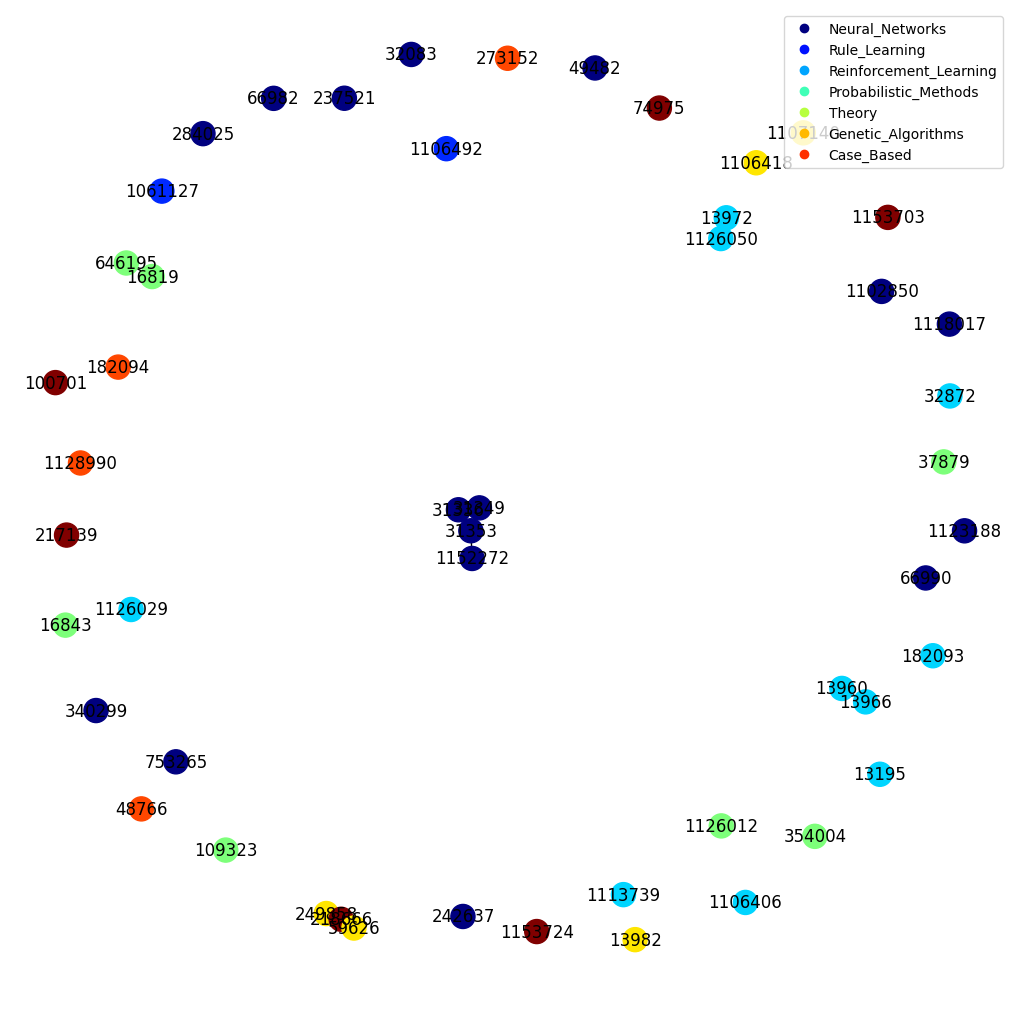

In [29]:
# Convert to NetworkX
Gnx = graph.to_networkx()

# Draw a subgraph with the first 50 nodes for simplicity
node_list = list(Gnx.nodes)[:50]
H = Gnx.subgraph(node_list)

# Create a color map based on the unique subjects
color_map = {str(node): idx for idx, node in enumerate(node_subjects.unique())}

# Get the corresponding colors for the selected nodes based on their subject
node_colors = [color_map[str(node_subjects[node])] for node in H.nodes()]

plt.figure(figsize=(10,10))
nx.draw(H, pos=nx.spring_layout(H, seed=42), with_labels=True, node_color=node_colors, cmap=plt.cm.jet)

# Adding legend
for subject in node_subjects.unique():
    color = plt.cm.jet(color_map[str(subject)] / len(node_subjects.unique()))
    plt.plot([], [], 'o', color=color, label=subject)

plt.legend(loc='upper right')
plt.show()

### Visualizing top 10 nodes with the highest degree of centrality in Cora dataset

threshold 0.011821204285186553


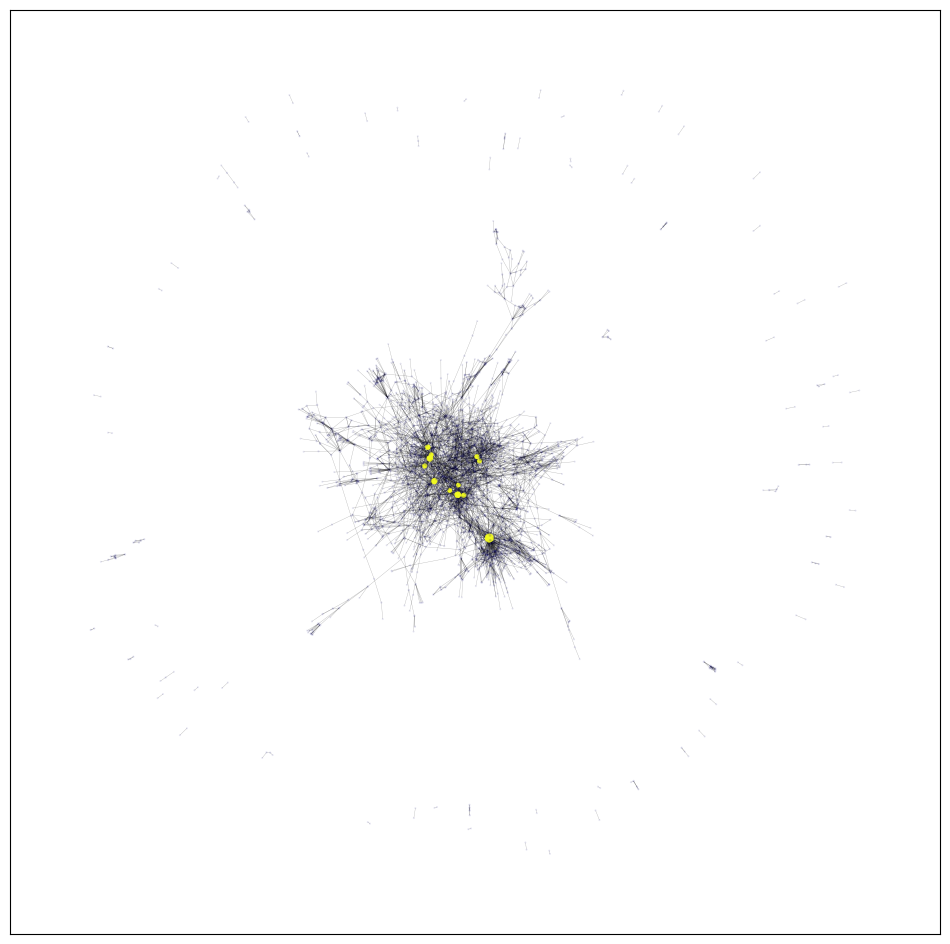

In [50]:
pos = nx.spring_layout(Gnx, seed=42)
cent = nx.degree_centrality(Gnx)
node_size = list(map(lambda x: x * 500, cent.values()))
cent_array = np.array(list(cent.values()))
threshold = sorted(cent_array, reverse=True)[10]
cent_bin = np.where(cent_array >= threshold, 1, 0.1)
plt.figure(figsize=(12, 12))
nodes = nx.draw_networkx_nodes(Gnx, pos, node_size=node_size,
                               cmap=plt.cm.plasma,
                               node_color=cent_bin,
                               nodelist=list(cent.keys()),
                               alpha=cent_bin, label=True)
edges = nx.draw_networkx_edges(Gnx, pos, width=0.25, alpha=0.3)
plt.show()
print("threshold", threshold)

### Graph embedding

In [31]:
# Create a data generator to convert the core graph structure and node features into an embedding
# The generator encodes the information required to produce the model inputs.
# It will yield data appropriate for the GCN algorithm specifically, by using the normalized graph Laplacian matrix to capture the graph structure
generator = FullBatchNodeGenerator(graph, method="gcn")

Using GCN (local pooling) filters...


In [32]:
# Build the model with the following parameters:
# layer_sizes: the number of hidden GCN layers and their sizes. Two GCN layers are used with 16 units each.
# activations: the activation to apply to each GCN layer’s output. RelU is used for both layers.
# dropout: the rate of dropout for the input of each GCN layer.
    
gcn = GCN(
    layer_sizes=[16, len(set(node_subjects))], activations=["relu", "relu"], generator=generator, dropout=0.5
)

In [33]:
# Get input and output tensors of the GCN model
x_inp, x_out = gcn.in_out_tensors()
x_out

<KerasTensor: shape=(1, None, 7) dtype=float32 (created by layer 'gather_indices_1')>

In [34]:
# Create a model that computes/predicts embeddings
embedding_model = Model(inputs=x_inp, outputs=x_out)

In [35]:
# Calling the flow method with a set of nodes aproduces an object that can be used to train the model on those nodes. 
all_gen = generator.flow(node_subjects.index)

In [36]:
# Compute embeddings for every node using the all_gen data.
embedding_stellar = embedding_model.predict(all_gen)
embedding_stellar.shape

1/1 [==============================] - 0s 260ms/step


(1, 2708, 7)

In [37]:
# Embeddings from the GCN model have a batch dimension of 1 so we squeeze this to get a matrix of node embeddings
X = embedding_stellar.squeeze(0)
X.shape

(2708, 7)

### Low dimension-reduction transform for visualization

In [38]:
transform = PCA # or TSNE

trans = transform(n_components=2)
X_reduced = trans.fit_transform(X)
X_reduced.shape

(2708, 2)

### Visualize node embedding

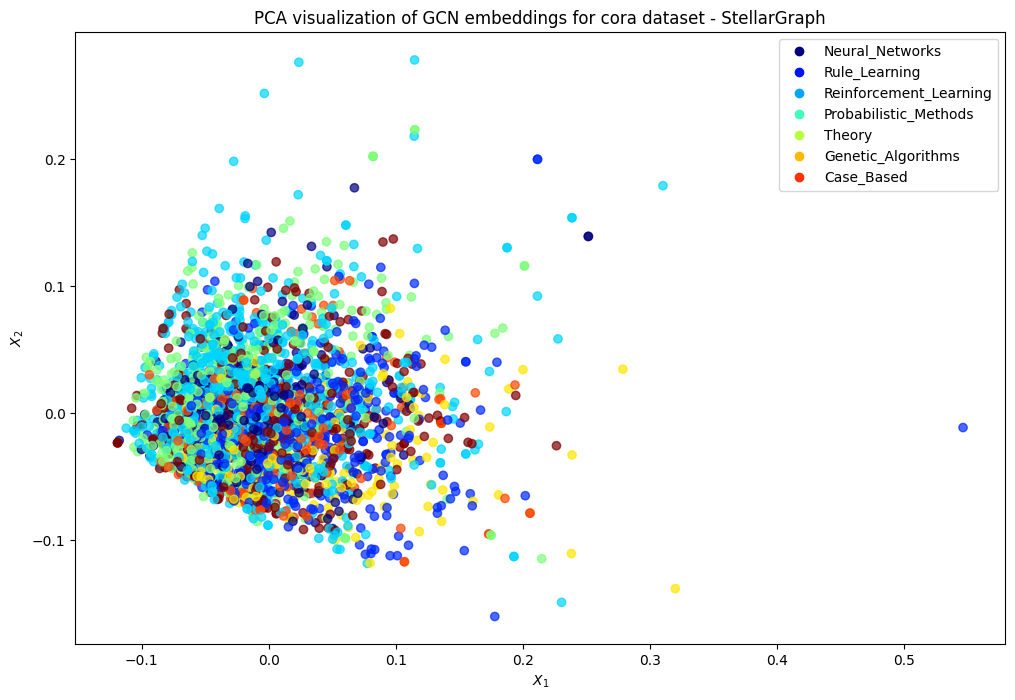

In [49]:
fig, ax = plt.subplots(figsize=(12, 12))
ax.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    c=node_subjects.astype("category").cat.codes,
    cmap="jet",
    alpha=0.7,
)
ax.set(
    aspect="equal",
    xlabel="$X_1$",
    ylabel="$X_2$",
    title=f"{transform.__name__} visualization of GCN embeddings for cora dataset - StellarGraph",
)

# Adding legend
for subject in node_subjects.unique():
    color = plt.cm.jet(color_map[str(subject)] / len(node_subjects.unique()))
    plt.plot([], [], 'o', color=color, label=subject)

plt.legend(loc='upper right')
plt.show()

# Graph embedding using PyG (PyTorch Geometric)

Follow these steps to install touch_geometric and its dependencies

```python
$conda create -n gml python=3.7
$conda activate gml
$conda install pytorch torchvision -c pytorch
$conda install torch_scatter
$conda install torch_sparse
$conda install torch_cluster
$conda install torch-spline-conv
$conda install tourch_geometric
$conda install osmnx

In [40]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv

### Load the Cora dataset

In [41]:
dataset = Planetoid(root='/tmp/Cora', name='Cora')

### Create a two-layer GCN model

In [42]:
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)
        self.dropout = torch.nn.Dropout(0.5)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x =  F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return x

 ### Train this model on the training nodes for 200 epochs

In [43]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

model.eval()
embeddings_pyg = model(data).detach().cpu().numpy()

print("Final Embeddings using GCN in PyG: ", embeddings_pyg)

Final Embeddings using GCN in PyG:  [[2023.4547 2080.1145 2110.6333 ... 2051.5083 2115.5635 2081.2883]
 [3093.3835 3180.074  3226.9866 ... 3144.064  3232.956  3181.213 ]
 [3142.0913 3230.3074 3277.9556 ... 3191.7256 3284.5146 3231.5332]
 ...
 [1644.4462 1690.2552 1714.9451 ... 1666.4976 1719.06   1691.2888]
 [2209.209  2271.1614 2304.9006 ... 2241.245  2310.1482 2272.1206]
 [2080.0664 2138.428  2170.112  ... 2109.987  2175.043  2139.3333]]


In [44]:
embeddings_pyg.shape

(2708, 7)

### Visualize node embedding

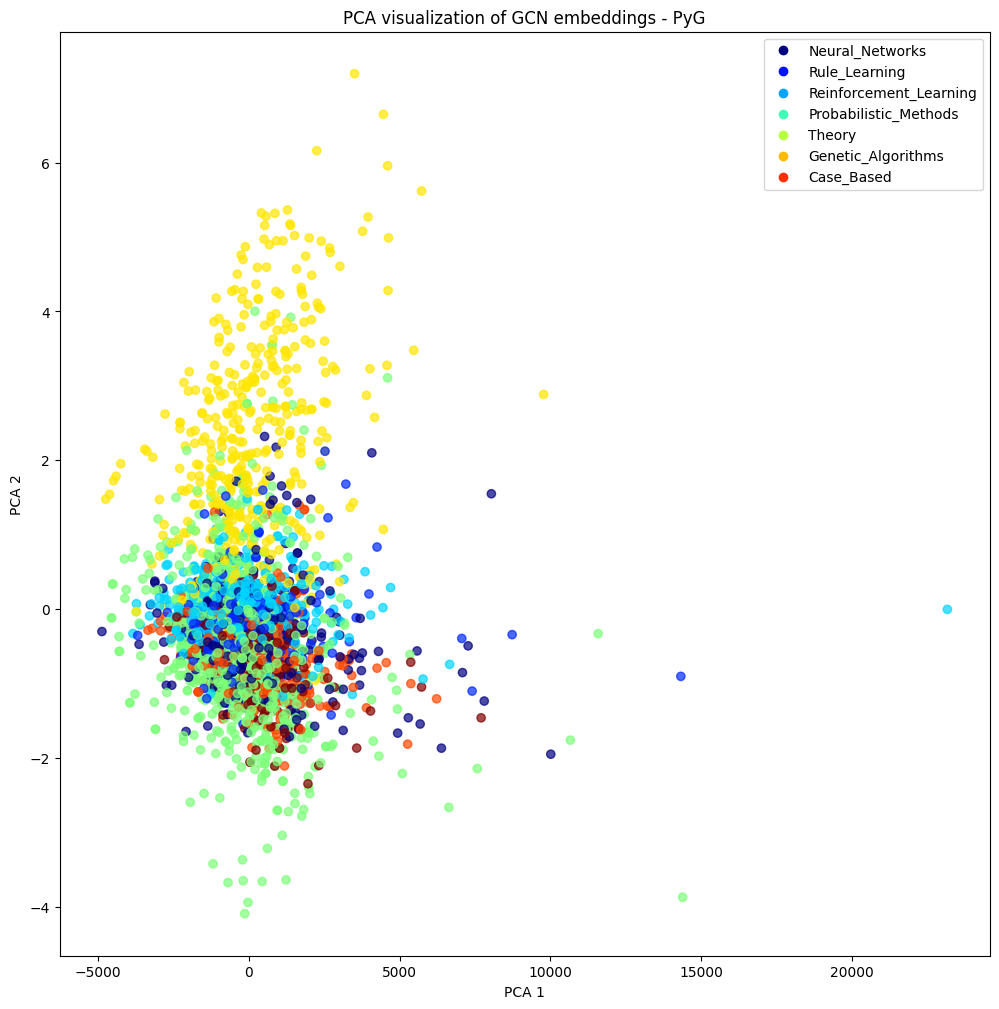

In [51]:
pca = PCA(n_components=2)
node_embeddings_2d = pca.fit_transform(embeddings_pyg)

# Get the class labels for each node
labels = data.y.cpu().numpy()

# Create a scatter plot of the 2-dimensional t-SNE embeddings
plt.figure(figsize=(12, 12))
plt.scatter(node_embeddings_2d[:, 0], node_embeddings_2d[:, 1], c=labels, cmap='jet', alpha=0.7)

# Adding legend
for subject in node_subjects.unique():
    color = plt.cm.jet(color_map[str(subject)] / len(node_subjects.unique()))
    plt.plot([], [], 'o', color=color, label=subject)

plt.legend(loc='upper right')

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('PCA visualization of GCN embeddings - PyG')
plt.show()
# plt.savefig('PyG_embeddings', dpi=300)